# Subsampling approaches to MCMC for tall data

Last modified on 11th May 2015

This notebook illustrates various approaches to subsampling MCMC, see (Bardenet, Doucet, and Holmes, ICML'14 and a 2015 arxiv preprint entitled "On MCMC for tall data" by the same authors. By default, executing cells from top to bottom will reproduce the running examples in the latter paper. If you want to jump to a particular method, you should at least evaluate the first two sections beforehand ("Generate..." and "Vanilla MH"), as they contain functions and data that is used throughout the notebook. Please report any issue (or interesting discovery!) to the paper's corresponding author.

**Table of contents**    
[Generate toy data](#Generate-toy-data)  
[Vanilla MH](#Vanilla-isotropic-Gaussian-random-walk-Metropolis)  
[Austerity MH](#Austerity-MH)  
[Confidence sampler without proxy](#Vanilla-confidence-sampler)  
[Poisson estimator](#Pseudo-marginal-MH-with-Poisson-estimator)  
[Confidence sampler with proxy](#Confidence-MH-with-2nd-order-Taylor-likelihood-proxy)  
[Firefly MH](#Firefly-MH-with-2nd-order-Taylor-lower-bound)  
[SGLD](#Stochastic-gradient-Langevin-dynamics)  


In [1]:
%pylab inline
figsize(10,10) # in the global namespace when inline backend is in use.

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import numpy.random as npr
import scipy.stats as sps
import scipy.special as spsp
import scipy.misc as spm
import scipy.optimize as spo
import numpy.linalg as npl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import sympy as sym
import time
import seaborn as sns
import seaborn.distributions as snsd
import math as math
sns.set(style="ticks");

plt.ioff() # turn off interactive plotting
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
npr.seed(1)

//anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


We will save Figures in the following directory, by default it is the current directory.

In [3]:
saveDirStr = ""

## Generate toy data

First, let us generate some data. Change variable "dataType" to switch between the Gaussian and the lognormal examples from the paper. 

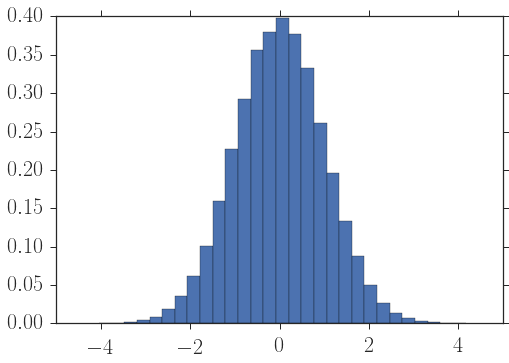

Mean of x = 0.00525302848968
Std of x = 0.998329273542


In [4]:
# Generate data
npr.seed(1)
N = 100000
dataType = "Gaussian"
#dataType = "logNormal"
if dataType == "Gaussian":
    x = npr.randn(N)
elif dataType == "logNormal":
    x = npr.lognormal(0,1,size=N)
plt.clf()
plt.hist(x, 30, normed=True)
plt.show()

# We store the mean and std deviation for later reference, they are also the MAP and MLE estimates in this case.
realMean = np.mean(x)
realStd = np.std(x)
print "Mean of x =", realMean
print "Std of x =", realStd

We are going to estimate the mean and std deviation of a Gaussian model, applied to the toy dataset generated above.

In [5]:
def getLogLhd(x, mu, sigma):
    """
    return an array of Gaussian log likelihoods up to a constant
    """
    return -(x-mu)**2/(2*sigma**2) - np.log(sigma)

In [6]:
def combineMeansAndSSQs(N1, mu1, ssq1, N2, mu2, ssq2):
    """
    combine means and sum of squares of two sets
    """
    dd = mu2 - mu1
    mu = mu1
    ssq = ssq1
    N = N1+N2
    mu += dd*N2/N
    ssq += ssq2
    ssq += (dd**2) * N1 * N2 / N
    return N, mu, ssq

The following function plots the results as in the paper. It is a bit messy, but you can safely skip this cell without missing anything on the algorithms.

In [7]:
def plotResults(S, ns, algoName="doesNotMatter", weights="doesNotMatter", boolSave=0, figId="basic"):
    """
    plot results
    """    
    # Plot joint sample with seaborn
    m = np.min(S[:,0]) # Precompute limits for x and y plots
    M = np.max(S[:,0])
    m_ref = np.min(S_ref[:,0]) # Precompute limits for x and y plots
    M_ref = np.max(S_ref[:,0])
    
    xlimInf = min(m, m_ref)# - (M-m)/10
    xlimSup = max(M, M_ref)# +(M-m)/10
    print "xlims =", xlimInf, xlimSup # +(M-m)/10
    xPlot = np.linspace(xlimInf, xlimSup, 1000)
    m = np.min(np.exp(S[:,1]))
    M = np.max(np.exp(S[:,1]))
    m_ref = np.min(np.exp(S_ref[:,1])) # Precompute limits for x and y plots
    M_ref = np.max(np.exp(S_ref[:,1]))
    ylimInf = min(m, m_ref)# - (M-m)/10
    ylimSup = max(M, M_ref)
    yPlot = np.linspace(ylimInf, ylimSup, 1000)
    
    if algoName == "sgld":
        # Need to convert a weighted sample into a unweighted sample
        sumWeights = np.sum(weights)
        normalizedWeights = weights/sumWeights
        T = S.shape[0]
        inds = npr.choice(np.arange(T), T, p=normalizedWeights)
        S = S[inds,:]
    
    g = sns.jointplot(S[:,0], np.exp(S[:,1]), kind="hex", space=0,size=10, xlim=(xlimInf,xlimSup), ylim=(ylimInf,ylimSup), stat_func=None, marginal_kws={"norm_hist":True}) # 
    plt.sca(g.ax_joint)
    plt.xlabel("$\mu$",)
    plt.ylabel("$\sigma$")
    
    # Add Reference long MH draw 
    # ... to the joint plot
    sns.kdeplot(S_ref[:,0], np.exp(S_ref[:,1]), ax=g.ax_joint, bw="silverman", cmap="BuGn_r", linewidth=5)
    # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, marg0(xPlot), 'g', linewidth=6, label="Ref")
    g.ax_marg_y.plot(marg1(yPlot), yPlot, 'g', linewidth=6)
    
    # Add Bernstein von Mises approximations
    # ... to the joint plot
    X, Y = np.meshgrid(xPlot, yPlot)
    minusFisher = np.array([[1./realStd**2, 0],[0, 2./realStd**2]])
    SS = 1./N*npl.inv(minusFisher)
    Z = plt.mlab.bivariate_normal(X, Y, sigmax=np.sqrt(SS[0,0]), mux=realMean, muy=realStd, sigmay=np.sqrt(SS[1,1]), sigmaxy=np.sqrt(SS[0,1])) # Plot BvM approximation
    g.ax_joint.contour(X, Y, -Z, 1, colors="r", label="BvM", linestyle='--',linewidths=(6))
    # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, sps.norm(realMean, np.sqrt(SS[0,0])).pdf(xPlot), color="red", linewidth=6, linestyle='--', label="BvM")
    g.ax_marg_y.plot(sps.norm(realStd, np.sqrt(SS[1,1])).pdf(yPlot), yPlot, color="red", linewidth=6, linestyle='--')
    
    # Print legend and save
    
    g.ax_marg_x.legend()
    print saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf"
    plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
      
    if boolSave:
        plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
        plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".eps")
    plt.show()    
        
    # Plot autocorr of second component
    c = plt.acorr(np.exp(S[:,1]), maxlags=50, detrend=detrend_mean, normed=True)
    plt.clf()
    c = c[1][c[0]>=0]
    plt.plot(c, linewidth=3)
    plt.plot(c_ref, label="Ref", linewidth=3, color="g")
    plt.grid(True)
    
    plt.legend(loc=1)
    if boolSave:
            plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".eps")
 
    plt.show()
      
    # Plot average number of likelihoods computed
    if not algoName =="vanillaMH":
        plt.hist(ns, histtype="stepfilled", alpha=.3)
        labStr = "mean="+str(np.around(1.0*np.mean(ns)/N*100,1))+"\%"
        plt.axvline(np.mean(ns), linewidth = 4, color="blue", label=labStr)
        labStr = "median="+str(np.around(1.0*np.median(ns)/N*100,1))+"\%"
        print "Median=", np.median(ns)
        plt.axvline(np.median(ns), linewidth = 4, color="blue",linestyle='--', label=labStr)
        plt.axvline(N, linewidth = 4, color="k", label="n") 
        plt.xlim([0, 2*N+1])
        plt.legend()
        if boolSave:
            plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".eps")
            print "Plots saved"
        plt.show()

In [8]:
# Concentration bounds
def ctBernsteinSerfling(N,n,a,b,sigma,delta):
    """
    Bernstein-type bound without replacement, from (Bardenet and Maillard, to appear in Bernoulli)
    """
    l5 = np.log(5/delta)
    kappa = 7.0/3+3/np.sqrt(2)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return sigma*np.sqrt(2*rho*l5/n) + kappa*(b-a)*l5/n

def ctHoeffdingSerfling(N,n,a,b,delta):
    """
    Classical Hoeffding-type bound without replacement, from (Serfling, Annals of Stats 1974)
    """
    l2 = np.log(2/delta)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return (b-a)*np.sqrt(rho*l2/2/n)

def ctBernstein(N,n,a,b,sigma,delta):
    """
    Classical Bernstein bound, see e.g. the book by Boucheron, Lugosi, and Massart, 2014.
    """
    l3 = np.log(3/delta)
    return sigma*np.sqrt(2*l3/n) + 3*(b-a)*l3/n

The proxies we use are Taylor expansions. We will need derivatives of the log likelihood up to order 3.

In [9]:
# Differential functions for proxies, 

# Define vectorized evaluation of gradient and Hessian
myGradientVect = lambda x_float, mu_float, sigma_float:np.array([-(2*mu_float - 2*x_float)/(2*sigma_float**2), -1/sigma_float + (-mu_float + x_float)**2/sigma_float**3]).T
myHessianVect = lambda x_float, mu_float, sigma_float:[[-1/sigma_float**2*np.ones(x_float.shape), 2*(mu_float - x_float)/sigma_float**3], [2*(mu_float - x_float)/sigma_float**3, (1 - 3*(mu_float - x_float)**2/sigma_float**2)/sigma_float**2]]

# Compute third order derivatives to bound the Taylor remainder. Symbolic differentiation is not really necessary in this simple case, but
# it may be useful in later applications
def thirdDerivatives():
    x, mu, sigma = sym.symbols('x, mu, sigma')
    L = []
    for i in range(4):
        for j in range(4):
            if i+j == 3:
                args = tuple([-(x-mu)**2/(2*sigma**2) -sym.log(sigma)] + [mu for cpt in range(i)] + [sigma for cpt in range(j)])                
                L.append( sym.diff(*args) )
    return L
    
def evalThirdDerivatives(x_float, mu_float, logSigma_float): 
    tt = thirdDerivatives()
    return [tt[i].subs('x',x_float).subs('mu',mu_float).subs('sigma',np.exp(logSigma_float)).evalf() for i in range(4)]

# Find the MAP (not really necessary here since the MAP are the mean and std deviation of the data)
f = lambda theta: -np.mean(getLogLhd(x, theta[0], np.exp(theta[1])))
thetaMAP = spo.minimize(f, np.array([realMean, np.log(realStd)])).x
print "MAP is", thetaMAP, "Real values are", realMean, np.log(realStd)
tt = thirdDerivatives()
print tt

MAP is [ 0.00525303 -0.00167212] Real values are 0.00525302848968 -0.00167212367818
[2*(-1 + 6*(mu - x)**2/sigma**2)/sigma**3, -6*(mu - x)/sigma**4, 2/sigma**3, 0]


## Vanilla isotropic Gaussian random walk Metropolis

In [10]:
def vanillaMH(T):
    """
    perform traditional isotropic random walk Metropolis
    """
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .5/np.sqrt(N)
    S = np.zeros((T, 2))
    acceptance = 0.0
    
    for i in range(T):
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        lhds = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        Lambda = np.mean(lhds)
        psi = 1./N*np.log(u)
        if Lambda>psi:
            thetaNew = thetaP
            theta = thetaP
            accepted = 1
            S[i,:] = thetaNew
        else:
            S[i,:] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            print "Iteration", i, "Acceptance", acceptance
            
    return S

Iteration 0 Acceptance 0.0
Iteration 5000 Acceptance 0.498900219956
Iteration 10000 Acceptance 0.505249475052
Iteration 15000 Acceptance 0.509499366709
Iteration 20000 Acceptance 0.513974301285
Iteration 25000 Acceptance 0.514499420023
Iteration 30000 Acceptance 0.51401619946
Iteration 35000 Acceptance 0.514328162053
Iteration 40000 Acceptance 0.514412139697
Iteration 45000 Acceptance 0.515877424946


//anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


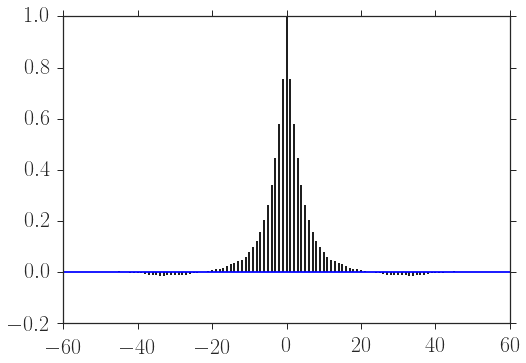

In [11]:
# Compute good marginals using a long run for later comparisons
S_ref = vanillaMH(50000)
marg0 = sps.gaussian_kde(S_ref[:,0])
marg1 = sps.gaussian_kde(np.exp(S_ref[:,1]))
c = plt.acorr(np.exp(S_ref[:,1]), maxlags=50, detrend=detrend_mean, normed=True);
c_ref = c[1][c[0]>=0]
plt.show()

In [12]:
S = vanillaMH(10000)

Iteration 0 Acceptance 1.0
Iteration 1000 Acceptance 0.497502497502
Iteration 2000 Acceptance 0.519740129935
Iteration 3000 Acceptance 0.526157947351
Iteration 4000 Acceptance 0.530617345664
Iteration 5000 Acceptance 0.534893021396
Iteration 6000 Acceptance 0.536910514914
Iteration 7000 Acceptance 0.536637623197
Iteration 8000 Acceptance 0.537057867767
Iteration 9000 Acceptance 0.537495833796


xlims = -0.0079417210621 0.0166650905611
chain_Gaussian_vanillaMH_basic.pdf


//anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


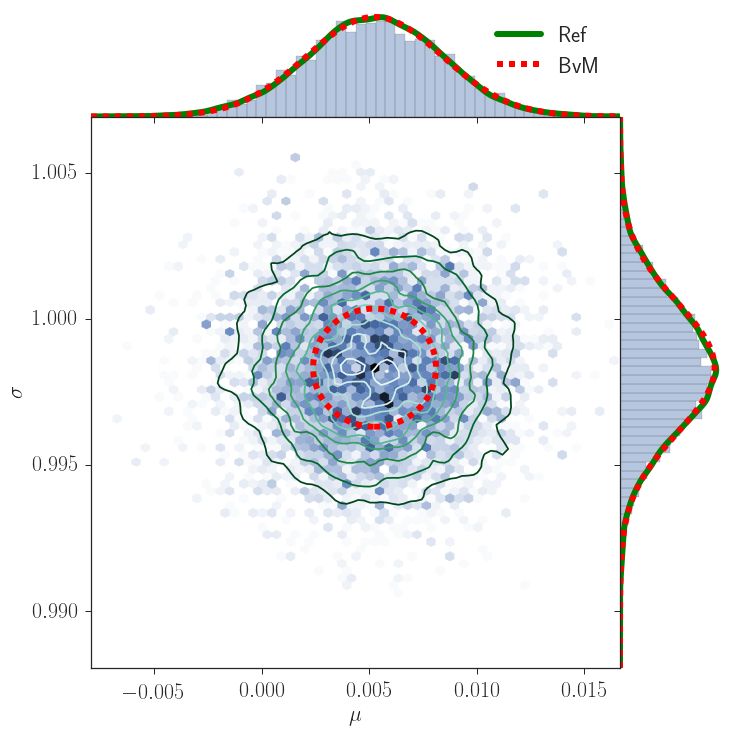

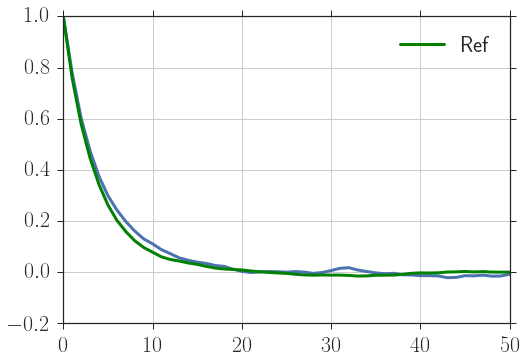

In [13]:
plotResults(S, [], algoName="vanillaMH", boolSave=1)

## Austerity MH

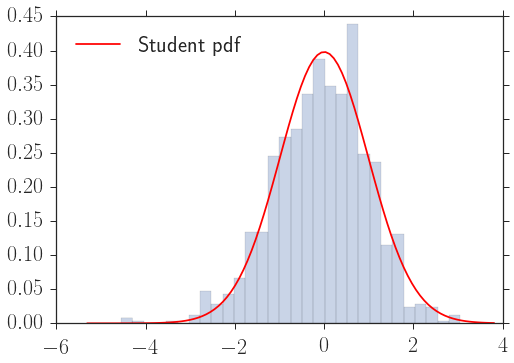

In [14]:
# Look at the distribution of Student statistics for a given value of (theta,theta')
# It depends on the data distribution, but also on the size n of the subsample and (theta, theta')

npr.seed(3)
theta = np.array([realMean,np.log(realStd)]) # Pick theta to be the MAP
thetaP = theta+1./np.sqrt(N)*npr.randn(2) 
numRepeats = 1000
students = np.zeros((numRepeats,))
n = 100
Lambda_N = np.mean(getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))) 
for j in range(numRepeats):
    npr.shuffle(x)
    lhds = getLogLhd(x[:n], thetaP[0], np.exp(thetaP[1])) - getLogLhd(x[:n], theta[0], np.exp(theta[1]))
    Lambda = np.mean(lhds)
    s = np.std(lhds)/np.sqrt(n)*np.sqrt(1-1.0*n/N)
    t = (Lambda-Lambda_N)/s
    students[j] = t

plt.hist(students,30,normed=True,alpha=0.3)
m = np.min(students)
M = np.max(students)
xplot = np.linspace(m-(M-m)/10, M+(M-m)/10, 100)
plt.plot(xplot, sps.t(n-1).pdf(xplot),'r', label="Student pdf")
plt.legend(loc=2)
plt.savefig(saveDirStr+"student_"+str(n)+"_"+dataType+"_"+"austerityMH"+".pdf")
plt.savefig(saveDirStr+"student_"+str(n)+"_"+dataType+"_"+"austerityMH"+".eps")

plt.show()

In [ ]:
def austerityMH(T):
    """
    perform Korattikara, Chen & Welling's austerity MH (ICML'14)
    """
    
    theta = np.array([realMean,np.log(realStd)])
    stepsize = 0.005
    S_K = np.zeros((T,2))
    eps = .05
    acceptance = 0.0
    gamma = 1.5
    ns_K = []
    
    for i in range(T):
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        psi = np.log(u)/N
        n = 100 # Size of first subsample used: this parameter is crucial but hard to set
    
        while not done and n<N:
            lhds = getLogLhd(x[:n], thetaP[0], np.exp(thetaP[1])) - getLogLhd(x[:n], theta[0], np.exp(theta[1]))
            Lambda = np.mean(lhds)
            s = np.std(lhds)/np.sqrt(n)*np.sqrt(1-1.0*n/N)
            t = (Lambda-psi)/s
            if 1 - sps.t(n-1).cdf(np.abs(t)) < eps:
                done = 1
            n = min(N,np.floor(gamma*n))
                
        if not done: # the test never rejected H_0
            lhds = getLogLhd(x[:N], thetaP[0], np.exp(thetaP[1])) - getLogLhd(x[:N], theta[0], np.exp(theta[1]))
            Lambda = np.mean(lhds)
            n = N
            
        if i>1 and ns_K[-1] == 2*N:
            ns_K.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_K.append(2*n)
        
        if Lambda>psi:
            theta = thetaP
            accepted = 1
            S_K[i] = thetaP
        else:
            S_K[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        
        if np.mod(i,T/10)==0:
            print "Iteration", i, "Acceptance", acceptance, "Avg. num. evals", np.mean(ns_K)
        
    return S_K, ns_K

In [ ]:
S_K, ns_K = austerityMH(10000)

In [ ]:
plotResults(S_K, ns_K, algoName="austerityMH", boolSave=1)

## Vanilla confidence sampler

In [ ]:
# Confidence MCMC (Bardenet, Doucet, and Holmes, ICML'14)

def confidenceMCMC(T):
    
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .01 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 1.5
    ns_B = []
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = N/10
        cpt = 0
        lhds = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        a = np.min(lhds)
        b = np.max(lhds)
            
        while not done and n<N:
        
            n = min(N,np.floor(gamma*n))
            cpt+=1
            deltaP = delta/2/cpt**2
            # The following step should be done differently to avoid recomputing previous likelihoods, but for the toy examples we keep it short
            lhds = getLogLhd(x[:n], thetaP[0], np.exp(thetaP[1])) - getLogLhd(x[:n], theta[0], np.exp(theta[1])) 
            Lambda = np.mean(lhds)
            sigma = np.std(lhds)
            psi = np.log(u)/N
            if np.abs(Lambda-psi) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n) # The algorithm required all likelihoods for theta and theta', next iteration we can reuse half of them
        
        if Lambda>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
            
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print "Iteration", i, "Acceptance", acceptance, "Avg. num evals", np.mean(ns_B), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", (b-a)/n
        
    return S_B, ns_B

In [ ]:
S_B, ns_B = confidenceMCMC(10000)

In [ ]:
plotResults(S_B, ns_B, boolSave=1, algoName="vanillaConfidence")

## Pseudo-marginal MH with Poisson estimator

In [ ]:
# define unbiased estimator
def logOfUnbiasedEstimate(batch, a, eps):
    """
    return log of unbiased estimator of [Rhee and Glynn, tech report 2013], as stated in [Jacob and Thiéry, to appear in AoS]
    """
    N = npr.geometric(eps/(1+eps))    # Draw geometric truncation level
    logw = np.arange(N)*np.log(1+eps)    # Compute everything in the log domain to avoid big products
    logfacts = np.array([math.lgamma(k) for k in range(2,N+2,1)])
    logprods = ( np.array([np.sum(np.log(batch[:k]-a)) for k in range(1,N+1,1)]) )
    logY = a + spm.logsumexp([0, spm.logsumexp(logw - logfacts + logprods)])
    return N, logY

We first test the above estimator by estimating $e^\mu$ with a sample from a Gaussian $\mathcal{N}(\mu,\sigma^2)$ or a gamma $\Gamma(\mu/1.5,1.5)$. Note that everything is computed in the log domain, so we actually compare the log of the average of the unbiased estimates and compare it to 
$\mu$.

In [ ]:
# test unbiased estimator on a simple example
eps = 0.001
L = []
mu = 1
sigma = 1
numRepeats = 1000
batchSize = 100

for i in range(numRepeats):
    #batch = mu + sigma*npr.randn(batchSize)
    batch = npr.gamma(mu/1.5,1.5,size=batchSize) # Try a gamma with mean mu
    a = np.min(batch)-1 # Control how loose the bound is
    L.append( logOfUnbiasedEstimate(batch, a, eps)[1] )

plt.hist(L, alpha=.3, histtype="stepfilled")
plt.axvline(mu, linewidth = 8, color="r", alpha = .3, label="mu")
plt.axvline(np.log(1./numRepeats)+spm.logsumexp(L), linestyle='--', linewidth = 4, color="g", label="log of avg. of estimates")
print "Mean", np.mean(L), "Var", np.var(L), "Exp(sigma2)", np.exp(sigma**2), "Exp(mu-a)2", np.exp((mu-a)**2)
plt.legend(loc=2)
plt.show()

In [ ]:
def poissonPseudoMarginalMH(T):
    """ 
    perform psudo-marginal MH with Poisson estimator of the likelihood
    """
    eps = .01
    batchSize = 1000 # Expected number of samples used is roughly batchSize/eps for small eps
    theta = np.array([realMean,np.log(realStd)])
    lhds = getLogLhd(x, theta[0], np.exp(theta[1]))
    batchLogLhds = np.array([np.sum(npr.choice(lhds, batchSize)) for j in range(20000)])
    a = np.min(batchLogLhds) # Set optimal bound, unrealistic
    
    numBatches, logPiHat = logOfUnbiasedEstimate(N*1./batchSize*batchLogLhds, N*1./batchSize*a, eps)
    ns_P = [batchSize*numBatches]
        
    stepsize = .1/np.sqrt(N)
    S_P = np.zeros((T, 2))
    #ns_P = []
    acceptance = 0.0
    
    for i in range(T):
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        tmp = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) # likelihoods to choose from
        lhdsP = np.array([np.sum(npr.choice(tmp, batchSize)) for j in range(100)]) # compute log likelihoods of batches
        aP = np.min(lhdsP) # Set optimal bound, unrealistic
        numBatchesP, logPiHatP = logOfUnbiasedEstimate(N*1./batchSize*lhdsP, N*1./batchSize*aP, eps) # note the renormalization N/batchSize
        
        Lambda = 1./N*(logPiHatP - logPiHat)
        psi = 1./N*np.log(u)
        #print "Lambda, Psi", Lambda, psi
        if Lambda>psi:
            # Accept
            S_P[i,:] = thetaP
            theta = thetaP
            logPiHat = logPiHatP
            accepted = 1
        else:
            # Reject
            S_P[i,:] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
            
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        ns_P.append(batchSize*numBatchesP) 
        if np.mod(i,T/10)==0:
            realLogLhd = np.sum(getLogLhd(x, theta[0], np.exp(theta[1])))
            print "Iteration", i, "Acceptance", acceptance, "logPiHat", logPiHat, "logPiHatP", logPiHatP, "real logLhd", realLogLhd
            
    return ns_P, S_P

In [ ]:
ns_P, S_P = poissonPseudoMarginalMH(1000)

In [ ]:
# Plot the chain
plt.plot(S_P[:,0])
plt.show()
plt.plot(S_P[:,1])
plt.show()

In [ ]:
plotResults(S_P, ns_P) # Not useful as we couldn't make the chain mix well enough

## Confidence MH with 2nd order Taylor likelihood proxy

We will need to bound the absolute value of the third derivatives.

In [ ]:
tt = thirdDerivatives()
print tt

To apply the two Taylor expansions, it is enough to bound them on the union of the two segments 
$$\{(1-t)\theta^\star+t\theta, t\in[0,1]\}\cup\{(1-t)\theta^\star+t\theta', t\in[0,1]\},$$
where $\theta=(\mu,\sigma)$. Given their form, it is enough to bound them by taking the max of their absolute values when $\vert x-\mu\vert$ is maximal and $\sigma$ minimal in this union. Since the code is a bit hard to read, we have added a simple check of the bound in the algorithm to convince the reader the bound is correct.

In [ ]:
# Confidence MCMC with proxy (Bardenet, Doucet, and Holmes, this submission)
def confidenceMCMCWithProxy(T):
    
    npr.seed(1)
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .01 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 2.
    ns_B = []
    
    # Compute some statistics of the data that will be useful for bounding the error and averaging the proxies    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    
    # Prepare total sum of Taylor proxys
    muMAP = thetaMAP[0]
    sigmaMAP = np.exp(thetaMAP[1])
    meanGradMAP = np.array( [(meanx - muMAP)/sigmaMAP**2, (meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**3 - 1./sigmaMAP] )
    meanHessMAP = np.array( [[-1./sigmaMAP**2, -2*(meanx-muMAP)/sigmaMAP**3], [-2*(meanx-muMAP)/sigmaMAP**3, -3*(meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**4 + 1/sigmaMAP**2]] )    
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = 2
        t0 = 0
        cpt = 0
        Lambda = 0
        ssq = 0 # Sum of squares
        
        # Prepare Taylor bounds
        xMinusMuMax = np.max(np.abs([1, minx-theta[0], maxx-theta[0], minx-thetaMAP[0], maxx-thetaMAP[0], minx-thetaP[0], maxx-thetaP[0]]))
        sigmaMin = np.min(np.exp([theta[1], thetaMAP[1], thetaP[1]]))
        R = float(np.max(np.abs(evalThirdDerivatives(xMinusMuMax, 0, np.log(sigmaMin)))))
        h = np.array([theta[0]-thetaMAP[0], np.exp(theta[1])-np.exp(thetaMAP[1])])
        hP = np.array([thetaP[0]-thetaMAP[0], np.exp(thetaP[1])-np.exp(thetaMAP[1])])
        R *= 2*1./6 * max(np.sum(np.abs(h)), np.sum(np.abs(hP)))**3
        a = -R
        b = R
        
        # We can already compute the average proxy log likelihood ratio
        avgTotalProxy = np.dot(meanGradMAP, hP-h) + .5*np.dot( hP-h, np.dot(meanHessMAP, h+hP) ) 
        
        while not done and n<N:
        
            n = min(N,np.floor(gamma*n))
            cpt+=1
            deltaP = delta/2/cpt**2
            batch = x[t0:n]
            lhds = getLogLhd(batch, thetaP[0], np.exp(thetaP[1])) - getLogLhd(batch, theta[0], np.exp(theta[1]))
            proxys = np.dot(myGradientVect(batch, muMAP, sigmaMAP), hP-h) + 0.5*np.dot(np.dot(hP-h, myHessianVect(batch,muMAP,sigmaMAP)).T, h+hP)
            if np.any(np.abs(lhds-proxys)>R):
                # Just a check that our error is correctly bounded
                print "Taylor remainder is underestimated"
            tmp, Lambda, ssq = combineMeansAndSSQs(t0, Lambda, ssq, n-t0, np.mean(lhds-proxys), (n-t0)*np.var(lhds-proxys))
            sigma = np.sqrt(1./n*ssq)
            psi = np.log(u)/N
            t0 = n
            if np.abs(Lambda-psi + avgTotalProxy) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n)
            
        if Lambda+avgTotalProxy>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print "Iteration", i, "Acceptance", acceptance, "Avg. num samples", np.mean(ns_B), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) ), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", R/n
        
    return S_B, ns_B

In [ ]:
S_BP, ns_BP = confidenceMCMCWithProxy(10000)

In [ ]:
plotResults(S_BP, ns_BP, algoName="confidenceProxy", boolSave=1)

## Confidence MCMC with proxys dropped along the way

This is a version of the confidence sampler with proxy that drops a proxy every 20 iterations.

In [ ]:
def dropProxy(thetaStar, meanx, minx, maxx, meanxSquared):
    """
    compute all quantities necessary to the evaluation of a proxy at thetaStar
    """
    muStar = thetaStar[0]
    sigmaStar = np.exp(thetaStar[1])
    meanGradStar = np.array( [(meanx - muStar)/sigmaStar**2, (meanxSquared-2*muStar*meanx+muStar**2)/sigmaStar**3 - 1./sigmaStar] )
    meanHessStar = np.array( [[-1./sigmaStar**2, -2*(meanx-muStar)/sigmaStar**3], [-2*(meanx-muStar)/sigmaStar**3, -3*(meanxSquared-2*muStar*meanx+muStar**2)/sigmaStar**4 + 1/sigmaStar**2]] )    
    return meanGradStar, meanHessStar

def confidenceMCMCWithProxyDroppedAlong(T):
    """
    perform confidence MCMC with proxy dropped every 20 iterations
    """
    npr.seed(1)
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .1 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 2.
    ns_B = []
    
    # Compute min and max of data    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    
    # Prepare Taylor proxys
    thetaStar = thetaMAP
    muStar = thetaStar[0]
    sigmaStar = np.exp(thetaStar[1])
    meanGradStar, meanHessStar = dropProxy(thetaStar, meanx, minx, maxx, meanxSquared)
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = 2
        t0 = 0
        cpt = 0
        Lambda = 0
        ssq = 0
        
        # Prepare Taylor bounds
        xMinusMuMax = np.max(np.abs([1, minx-theta[0], maxx-theta[0], minx-thetaStar[0], maxx-thetaStar[0], minx-thetaP[0], maxx-thetaP[0]]))
        sigmaMin = np.min(np.exp([theta[1], thetaStar[1], thetaP[1]]))
        R = float(np.max(np.abs(evalThirdDerivatives(xMinusMuMax, 0, np.log(sigmaMin)))))
        h = np.array([theta[0]-thetaStar[0], np.exp(theta[1])-np.exp(thetaStar[1])])
        hP = np.array([thetaP[0]-thetaStar[0], np.exp(thetaP[1])-np.exp(thetaStar[1])])
        R *= 2*1./6 * max(np.sum(np.abs(h)), np.sum(np.abs(hP)))**3
        a = -R
        b = R
        
        avgTotalProxy = np.dot(meanGradStar, hP-h) + .5*np.dot( hP-h, np.dot(meanHessStar, h+hP) ) 
        
        while not done and n<N:
        
            n = min(N,np.floor(gamma*n))
            
            if not np.mod(i,20): # Loop over whole dataset and recompute proxys when finished
                n = N
            
            cpt+=1
            deltaP = delta/2/cpt**2
            batch = x[t0:n]
            lhds = getLogLhd(batch, thetaP[0], np.exp(thetaP[1])) - getLogLhd(batch, theta[0], np.exp(theta[1]))
            proxys = np.dot(myGradientVect(batch, muStar, sigmaStar), hP-h) + 0.5*np.dot(np.dot(hP-h, myHessianVect(batch,muStar,sigmaStar)).T, h+hP)
            if np.any(np.abs(lhds-proxys)>R):
                print "Taylor remainder is underestimated"
            tmp, Lambda, ssq = combineMeansAndSSQs(t0, Lambda, ssq, n-t0, np.mean(lhds-proxys), (n-t0)*np.var(lhds-proxys))
            sigma = np.sqrt(1./n*ssq)
            psi = np.log(u)/N
            t0 = n
            #print "n, abs(L-psi), bound, sigma/sqrt(n), R/n", n, np.abs(Lambda-psi), ctBernstein(N,n,a,b,sigma,deltaP), sigma/np.sqrt(n), R/n
            if np.abs(Lambda-psi + avgTotalProxy) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n)
            
        if not np.mod(i,20): # Recompute proxys every 20 iterations
            thetaStar = theta
            muStar = thetaStar[0]
            sigmaStar = np.exp(thetaStar[1])
            meanGradStar, meanHessStar = dropProxy(thetaStar, meanx, minx, maxx, meanxSquared)
                
        if Lambda+avgTotalProxy>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print "Iteration", i, "Acceptance", acceptance, "Avg. num samples", np.mean(ns_B), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) ), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", R/n
        
    return S_B, ns_B

In [ ]:
S_BPD, ns_BPD = confidenceMCMCWithProxyDroppedAlong(10000)

In [ ]:
plotResults(S_BPD, ns_BPD)

## Firefly MH with 2nd order Taylor lower bound

In [ ]:
# Firefly MH with same Taylor bound as the confidence sampler with proxy
def fireflyMHWithTaylorBound(T):
    
    # Initialize
    theta = np.array([realMean, np.log(realStd)]) 
    z = np.zeros((N,))
    z[npr.randint(0, N, N/10)] = 1 # Start with 10% bright points
    stepsize = 1./np.sqrt(N) 
    S = np.zeros((T,2))
    acceptance = 0.0
    ns = []
    nsBright = []
    resampleFraction = .1 # Try resampling this fraction of the z's at each iteration
    numResampledZs = int(np.ceil(N*resampleFraction))
    
    # Compute min and max of data    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    print "min and max computed"
    
    # Prepare total sum of Taylor proxys
    muMAP = thetaMAP[0]
    sigmaMAP = np.exp(thetaMAP[1])
    logLhdMAP = getLogLhd(x, muMAP, sigmaMAP)
    meanGradMAP = np.array( [(meanx - muMAP)/sigmaMAP**2, (meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**3 - 1./sigmaMAP] )
    meanHessMAP = np.array( [[-1./sigmaMAP**2, -2*(meanx-muMAP)/sigmaMAP**3], [-2*(meanx-muMAP)/sigmaMAP**3, -3*(meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**4 + 1/sigmaMAP**2]] )    
    print "Taylor preprocessing done"
    
    for i in range(T):
        
        accepted = 0
        done = 0
        
        #-----------------------------------------------------
        # Prepare proposal on theta and MH's uniform draw
        #-----------------------------------------------------
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        psi = 1./N*np.log(u)
        
        #-----------------------------------------------------
        # Prepare Taylor bounds
        #-----------------------------------------------------
        xMinusMuMax = np.max(np.abs([1, minx-theta[0], maxx-theta[0], minx-thetaMAP[0], maxx-thetaMAP[0], minx-thetaP[0], maxx-thetaP[0]]))
        sigmaMin = np.min(np.exp([theta[1], thetaMAP[1], thetaP[1]]))
        R = float(np.max(np.abs(evalThirdDerivatives(xMinusMuMax, 0, np.log(sigmaMin)))))
        RP = R # We could tighten the bounds by considering theta and thetaP separately. Given the results, this is unnecessary
        
        h = np.array([theta[0]-thetaMAP[0], np.exp(theta[1])-np.exp(thetaMAP[1])])
        hP = np.array([thetaP[0]-thetaMAP[0], np.exp(thetaP[1])-np.exp(thetaMAP[1])]) 
        
        R *= 1./6 * np.sum(np.abs(h))**3 # no multiplication by 2 since only one point
        RP *= 1./6 * np.sum(np.abs(hP))**3 # no multiplication by 2 since only one point
    
        avgLogBound = np.mean(logLhdMAP) + np.dot(meanGradMAP, h) + .5*np.dot( h, np.dot(meanHessMAP, h) ) - R
        avgLogBoundP = np.mean(logLhdMAP) + np.dot(meanGradMAP, hP) + .5*np.dot( hP, np.dot(meanHessMAP, hP) ) - RP
        
        #-----------------------------------------------------
        # Resample z's
        #-----------------------------------------------------
        resampledInds = npr.randint(0, N, size=numResampledZs)
        L = np.exp(getLogLhd(x[resampledInds], theta[0], np.exp(theta[1])))
        logB = logLhdMAP[resampledInds] + np.dot(myGradientVect(x[resampledInds], muMAP, sigmaMAP), h) + 0.5*np.dot(np.dot(h, myHessianVect(x[resampledInds], muMAP, sigmaMAP)).T, h) - R
        B = np.exp(logB)
        z[resampledInds] = npr.binomial(1, 1-B/L)
        
        #-----------------------------------------------------
        # Compute posterior for acceptance of theta move
        #-----------------------------------------------------
        indsBright = z==1
        numBright = np.sum(indsBright)
        logB = logLhdMAP[indsBright] + np.dot(myGradientVect(x[indsBright], muMAP, sigmaMAP), h) + 0.5*np.dot(np.dot(h, myHessianVect(x[indsBright], muMAP, sigmaMAP)).T, h) - R
        B = np.exp(logB) 
        L = np.exp(getLogLhd(x[indsBright], theta[0], np.exp(theta[1])))
        logBP = logLhdMAP[indsBright] + np.dot(myGradientVect(x[indsBright], muMAP, sigmaMAP), hP) + 0.5*np.dot(np.dot(hP, myHessianVect(x[indsBright], muMAP, sigmaMAP)).T, hP) - RP
        BP = np.exp(logBP) 
        LP = np.exp(getLogLhd(x[indsBright], thetaP[0], np.exp(thetaP[1])))
        
        #-----------------------------------------------------
        # Accept/reject step
        #-----------------------------------------------------
        Lambda = (avgLogBoundP-avgLogBound) # sum of log of bounds
        Lambda += 1./N*( np.sum(np.log(LP/BP - 1)) - np.sum(np.log(L/B - 1)) ) # if the lower bound is wrong, this will raise a flag
        if Lambda > psi:
            # Accept
            theta = thetaP
            accepted = 1
            S[i] = thetaP
        else:
            # Reject
            S[i] = theta
        
        #-----------------------------------------------------
        # Save number of evaluations of the likelihood during this iteration
        #-----------------------------------------------------
        ns.append(numBright + numResampledZs) # This is an upper estimate of the number of cost units
        nsBright.append(numBright)
        
        #-----------------------------------------------------
        # Update stepsize, acceptance and print status
        #-----------------------------------------------------
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        #print "t4=", time.time() - tic
        
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print "Iteration", i, "Acceptance", int(100*acceptance), "% Avg. num lhds", np.mean(ns), "Avg num bright samples", np.mean(nsBright), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) )
        
    return S, ns, nsBright

In [ ]:
S_F, ns_F, nsBright_F = fireflyMHWithTaylorBound(10000)

In [ ]:
plotResults(S_F[1000:,], ns_F[1000:], algoName="fireflyMH", boolSave=0, figId="resampling10p")
plt.show()
plt.plot(nsBright_F)

## Stochastic gradient Langevin dynamics

In [ ]:
def sgld(T):
    """
    perform SGLD using constant or decreasing stepsizes
    """
    theta = np.array([realMean, np.log(realStd)])
    S = np.zeros((T,2))
    acceptance = 0.0
    ns = []
    M = N/10. # Size of the subsample
    weights = np.zeros((T,))
    
    for i in range(T):
        stepsize = .1/N/((i+1)**.33)
        weights[i] = stepsize
        inds = npr.randint(0,N,size=M)
        gradEstimate = N/M*np.sum(myGradientVect(x[inds], theta[0], np.exp(theta[1])), 0)
        theta[0] = theta[0] + stepsize*gradEstimate[0] + np.sqrt(stepsize)*npr.randn()
        theta[1] = np.log(np.exp(theta[1]) + stepsize*gradEstimate[1] + np.sqrt(stepsize)*npr.randn())
        ns.append(M)
        S[i,:] = theta
        if np.mod(i,T/10)==0:
            print "Iteration", i
            
    return S, ns, weights # SGLD returns a weighted sample, unlike other methods in this notebook

In [ ]:
S_SGLD, ns_SGLD, weights = sgld(10000)

In [ ]:
plotResults(S_SGLD, ns_SGLD, algoName="sgld", weights=weights, boolSave=1, figId="batchsize10p_length10k")